# Generalized Weighted Max-cut Solver

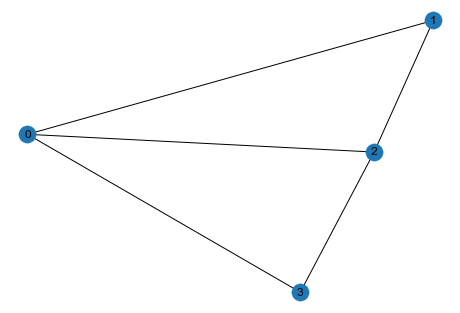

In [215]:
import networkx as nx
from matplotlib import pyplot as plt

"""INPUTS -- ENTER NUMBER OF NODES AND EDGE SPECIFICATIONS HERE"""
nodes = range(4)                                           # Insert the number of nodes on your graph in the range function
E     =[(0,1,0.5),(1,2,2),(2,0,1.5), (2,3,1.7), (0,3,0.5)] # Each edge in array is formatted as (start_node, end_node, weight)

### Visualize graph
G = nx.Graph() 
G.add_nodes_from(nodes)
G.add_weighted_edges_from(E)

pos          = nx.spring_layout(G)
default_axis = plt.axes(frameon=False)

nx.draw_networkx(G, ax=default_axis)

In [216]:
import cirq
import numpy as np
import math
from matplotlib import pyplot as plt
import random
from scipy.optimize import minimize

# Defines the list of qubits
num = len(nodes)
depth = 4
shots = 1000
qubits = [cirq.GridQubit(0, i) for i in range(0, num)]

"""Initializes all qubits into uniform superposition"""
def initialization(qubits):
    for i in qubits:
        yield cirq.H.on(i)

In [217]:
"""Defines the cost unitary -- encodes time evolution of cost Hamiltonian"""
def cost_unitary(qubits, gamma):
    for i in E:
        start_node = i[0]    #start node of edge
        end_node = i[1]      #end node of edge
        w = i[2]             #weight of edge
        # Encoding time evolution operator (exponentiated cost Hamiltonian) onto circuit
        yield cirq.ZZPowGate(exponent=-1*w*gamma/math.pi).on(qubits[start_node], qubits[end_node])

"""Defines the mixer unitary -- encodes time evolution of Hamiltonian that doesn't commute with cost Hamiltonian"""
def mixer_unitary(qubits, alpha):
    for i in range(0, len(qubits)):
        # Increasing the probability of measurement for states marked by cost unitary 
        yield cirq.XPowGate(exponent=-1*alpha/math.pi).on(qubits[i])

In [218]:
"""Executes the circuit"""
def create_circuit(params):
    gamma = [params[0], params[2], params[4], params[6]] # parameters for each cost layer
    alpha = [params[1], params[3], params[5], params[7]] # parameters for each mixer layer

    circuit = cirq.Circuit()
    circuit.append(initialization(qubits)) # Initializing all qubits by applying a Hadamard transform
    
    """For each layer, append a cost layer and a mixer layer to the circuit consecutively with the matching parameters"""
    for i in range(0, depth):
        circuit.append(cost_unitary(qubits, gamma[i]))
        circuit.append(mixer_unitary(qubits, alpha[i]))
    
    circuit.append(cirq.measure(*qubits, key='x')) # Measure the circuit

    """Conducts several shots of the circuit to inspect probability distribution and output bitstrings that were measured"""
    simulator = cirq.Simulator()
    results = simulator.run(circuit, repetitions=shots)
    results = str(results)[2:].split(", ")
    new_res = []
    for i in range(0, shots):
        hold = []
        for j in range(0, num):
            hold.append(int(results[j][i]))
        new_res.append(hold)
    return new_res

Now, we are able to create our cost function, in order to post-process the data measured from the quantum circuit executions. The cost function we made here returns a negative value (dependant on the weight) if the nodes are coloured differently and returns 0 if they are coloured the same. Thus, the objective is to minimize the cost function.

In [219]:
"""Defines the cost function -- runs one epoch"""
def cost_function(params): 
    res = create_circuit(params)
    total_cost = 0
    """Iterate over each result"""
    for i in range(0, len(res)):
        """Iterate over each edge in each result"""
        for j in E:
            start_node = j[0]
            end_node = j[1]
            w = j[2]
            """Calculate the cost of each edge and add it to the total cost"""
            total_cost = total_cost + -1*(w*res[i][start_node]*(1-res[i][end_node]) + w*res[i][end_node]*(1-res[i][start_node]))
    
    """Calculates the average cost over 1000 repitions of the algorithm"""
    total_cost = float(total_cost)/shots 
    print("Cost: "+str(total_cost))

    return total_cost

Cost: -3.689699999999952
Cost: -3.295199999999976
Cost: -3.6761999999999526
Cost: -1.284400000000003
Cost: -2.8250999999999817
Cost: -1.067600000000003
Cost: -3.1290999999999665
Cost: -3.5609999999999724
Cost: -3.065599999999975
Cost: -3.3553999999999795
Cost: -1.7428000000000081
Cost: -4.361499999999934
Cost: -3.87489999999996
Cost: -4.204099999999937
Cost: -4.418099999999933
Cost: -4.29179999999993
Cost: -4.317099999999939
Cost: -4.2596999999999365
Cost: -3.900199999999944
Cost: -4.530899999999927
Cost: -4.209299999999938
Cost: -4.623999999999934
Cost: -3.9697999999999607
Cost: -4.5365999999999325
Cost: -4.671499999999932
Cost: -4.634699999999931
Cost: -4.662299999999928
Cost: -4.670999999999929
Cost: -4.70239999999993
Cost: -4.636799999999935
Cost: -4.641399999999937
Cost: -4.751799999999927
Cost: -4.756699999999924
Cost: -4.8101999999999245
Cost: -4.736799999999926
Cost: -4.807999999999925
Cost: -4.736299999999925
Cost: -4.730199999999927
Cost: -4.80909999999992
Cost: -4.7571999999

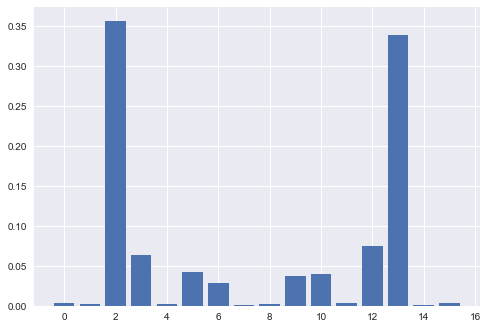

In [220]:
"""Defines a classical optimizer to tune the gamma and alpha parameters to minimize the expected value of the cost function"""
init =[float(random.randint(-314, 314))/float(100) for i in range(0, 8)]
out = minimize(cost_function, x0=init, method="COBYLA", options={'maxiter':100})

optimal_params = out['x']
f = create_circuit(optimal_params)

"""Creates visualization of the optimal state"""
nums = []
freq = []

### Iterating through all results and calculating frequency of results
for i in range(0, len(f)):
    number = 0
    # Converting result bit string into integer value
    for j in range(0, len(f[i])):
        number += 2**(len(f[i])-j-1)*f[i][j]
    # Recording result
    if (number in nums):
        freq[nums.index(number)] = freq[nums.index(number)] + 1
    else:
        nums.append(number)
        freq.append(1)

freq = [s/sum(freq) for s in freq] # Scaling frequencies to sum to one

x = range(0, 2**num)
y = []
for i in range(0, len(x)):
    if (i in nums):
        y.append(freq[nums.index(i)])
    else:
        y.append(0)

plt.style.use("seaborn")
plt.bar(x, y)
plt.show()

Above you can see a histogram showing the probabilities corresponding to each bitstring. Since this has been run on the optimal parameters, we know that the two states with the highest probability of being measured are the solutions to our weighted max-cut problem! As you can see, in this case the states with highest probability of measurement are $|2⟩ = |0010⟩$ and $|13⟩ = |1101⟩$. These are the two optimal solutions to MaxCut for our graph, I implore you to check it on your own! 